# ARMD Dataset Preprocessing

In [2]:
import pyarrow.parquet as pq
import glob
import os

id_columns = ['pat_enc_csn_id_coded', 'order_proc_id_coded', 'order_time_jittered_utc']
sample_folder='output/'
parquet_files = glob.glob(sample_folder + "*.parquet") 
sample_file = 'output/'+ os.path.basename(parquet_files[0])

print(f'Sample file: {os.path.basename(parquet_files[0])}')

table = pq.ParquetFile(sample_file)
df_batch = None
for batch in table.iter_batches(batch_size=5):
    df_batch = batch.to_pandas()
    break

df_batch.head()

Sample file: part.0.parquet


,pat_enc_csn_id_coded,order_proc_id_coded,order_time_jittered_utc,ordering_mode_x,culture_description_x,was_positive_x,organism_x,antibiotic_x,susceptibility_x,adi_score,...,first_diasbp,last_diasbp,last_sysbp,first_sysbp,last_temp,first_temp,last_resprate,first_resprate,last_heartrate,first_heartrate
0,131331407544,790098057,2022-05-14 02:29:00+00:00,Inpatient,URINE,1,ESCHERICHIA COLI,Ceftriaxone,Susceptible,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,79.0
1,131331407544,790098057,2022-05-14 02:29:00+00:00,Inpatient,URINE,1,ESCHERICHIA COLI,Ceftriaxone,Susceptible,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,79.0
2,131331407544,790098057,2022-05-14 02:29:00+00:00,Inpatient,URINE,1,ESCHERICHIA COLI,Ceftriaxone,Susceptible,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,79.0
3,131331407544,790098057,2022-05-14 02:29:00+00:00,Inpatient,URINE,1,ESCHERICHIA COLI,Ceftriaxone,Susceptible,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,79.0
4,131331407544,790098057,2022-05-14 02:29:00+00:00,Inpatient,URINE,1,ESCHERICHIA COLI,Ceftriaxone,Susceptible,17,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,77.0,79.0


# Prepare the target 
The target is `susceptibility` column 

In [4]:
import pandas as pd

sample_folder='output/'
parquet_files = glob.glob(sample_folder + "*.parquet") 
sample_file = 'output/'+ os.path.basename(parquet_files[0])

df = pd.read_parquet(sample_file, columns=['susceptibility'])
df['susceptibility'].value_counts()

susceptibility
Susceptible                     1249228
Resistant                        934967
Null                             459244
Intermediate                     259190
No Interpretation                    58
Susceptible - Dose Dependent         15
Name: count, dtype: Int64

Map susceptibility values as:
- `'Susceptible' → 'S'`
- `'Resistant' → 'R'`

Drop:
- `'Intermediate' → 'I'`
- `'Null'`
- `'No Interpretation'`
- `'Susceptible - Dose Dependent'`

In [7]:
import pyarrow.parquet as pq
import pyarrow as pa
import os
import glob
import pandas as pd

sample_folder = 'output/'
cleaned_folder = 'cleaned_output/'
os.makedirs(cleaned_folder, exist_ok=True)

# Target mapping
keep_values = {
    'Susceptible': 'S',
    'Resistant': 'R',
}

batch_size = 100_000
parquet_files = glob.glob(os.path.join(sample_folder, "*.parquet"))

for file_path in parquet_files:
    print(f"Processing: {os.path.basename(file_path)}")

    table = pq.ParquetFile(file_path)
    output_path = os.path.join(cleaned_folder, os.path.basename(file_path))
    writer = None
    base_schema = None

    for batch in table.iter_batches(batch_size=batch_size):
        df = batch.to_pandas()

        # Filter + map susceptibility
        df = df[df['susceptibility'].isin(keep_values)].copy()
        df['susceptibility_label'] = df['susceptibility'].map(keep_values)

        if df.empty:
            continue

        # Convert to pyarrow Table
        batch_table = pa.Table.from_pandas(df, preserve_index=False)

        if writer is None:
            base_schema = batch_table.schema
            writer = pq.ParquetWriter(output_path, base_schema)
        else:
            # Cast to initial schema to prevent mismatch
            batch_table = batch_table.cast(base_schema)

        writer.write_table(batch_table)

    if writer:
        writer.close()
        print(f"Saved cleaned file: {output_path}")
    else:
        print(f"No valid rows written: {file_path}")


Processing: part.0.parquet
Saved cleaned file: cleaned_output/part.0.parquet


In [9]:
import pandas as pd
import os
import glob

sample_clean_folder='cleaned_output/'
parquet_clean_files = glob.glob(sample_clean_folder + "*.parquet") 
sample_clean_file = sample_clean_folder + os.path.basename(parquet_clean_files[0])

df = pd.read_parquet(sample_clean_file, columns=['susceptibility_label'])
print(df.shape)
print(df['susceptibility_label'].value_counts())


(2184195, 1)
susceptibility_label
S    1249228
R     934967
Name: count, dtype: int64


# Visualize class distribution:

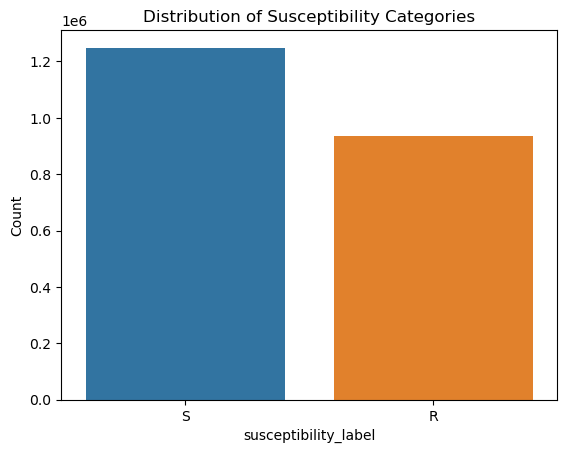

In [24]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(x='susceptibility_label', data=df, order=['S', 'R'])
plt.title("Distribution of Susceptibility Categories")
plt.ylabel("Count")
plt.show()


### Imbalance Analysis

#### Imbalance Ratio
The imbalance ratio is calculated as:

$$
\text{Imbalance Ratio} = \frac{\text{Majority Class Count}}{\text{Minority Class Count}}
$$

**Here:**
- **Majority class** = `S` (1,249,228 samples)  
- **Minority class** = `R` (934,967 samples)  

$$
\text{Imbalance Ratio} = \frac{1,249,228}{934,967} \approx 1.34
$$

---

### Interpretation
- **Mild Imbalance**: A ratio of **1.34:1** suggests a slight imbalance, but it is **not severe** (typically, ratios > **2:1** are considered imbalanced).  
- **No Major Concern**: Since the minority class (`R`) still has a significant number of samples (~934K), standard machine learning models should work fine.  

---

# Feature selection

**Target Column**

- `susceptibility` → already binary (`S` vs `R`)

**Core Predictive Features**
These are critical microbiological context:

- `organism_x` or `organism_left` or `organism_right` (choose one consistent source)
- `antibiotic_x` or `antibiotic_left` or `antibiotic_right` (same as above)
- `resistant_time_to_culturetime` (temporal resistance clue)

**Demographic & Socioeconomic Features**
These can capture patterns in resistance across populations:

- `age`
- `gender`
- `adi_score`, `adi_state_rank` (Area Deprivation Index)

**Lab Results (Quantitative Features)**
Time-windowed lab stats are excellent:

- WBC, neutrophils, lymphocytes, HGB, PLT, Na, HCO3, BUN, CR, lactate, procalcitonin
- Use median or all three (`Q25_`, `median_`, `Q75_`)
- Also useful: `first_` and `last_` versions (can show dynamics)

I may drop redundant summaries or keep only the most informative (e.g., median + first).

**Vital Signs**
These can indicate infection severity:
- `median_temp`, `median_resprate`, `median_heartrate`, `median_sysbp`, - `median_diasbp`
(I can optionally include quartiles or trends using first/last)

**Treatment Context**
Pre-treatment can influence resistance:

- `medication_name` (categorical, may need embedding or frequency encoding)
- `medication_category` (higher-level encoding)
- `medication_time_to_culturetime` (temporal feature)

**Administrative/Metadata to Drop**
Should be excluded:
- `pat_enc_csn_id_coded` 
- `order_proc_id_coded` 
- `order_time_jittered_utc` 
Any redundant _x, _y, _left, _right if duplicates exist

In [37]:
selected_features = [
    # Microbiology
    'organism_x', 'antibiotic_x', 'resistant_time_to_culturetime',

    # Demographics
    'age', 'gender', 'adi_score', 'adi_state_rank',

    # Labs (keep medians to reduce redundancy)
    'median_wbc', 'median_neutrophils', 'median_lymphocytes',
    'median_hgb', 'median_plt', 'median_na',
    'median_hco3', 'median_bun', 'median_cr',
    'median_lactate', 'median_procalcitonin',

    # Vitals
    'median_heartrate', 'median_resprate', 'median_temp',
    'median_sysbp', 'median_diasbp',

    # Treatment
    'medication_category', 'medication_time_to_culturetime',

    # Social
    'nursing_home_visit_culture'
]


In [47]:
import pandas as pd
import os
import glob

sample_clean_folder='cleaned_output/'
parquet_clean_files = glob.glob(sample_clean_folder + "*.parquet") 
sample_clean_file = sample_clean_folder + os.path.basename(parquet_clean_files[0])

# Add the target column
target_column = 'susceptibility_label' 
all_columns = selected_features + [target_column]

df = pd.read_parquet(sample_clean_file, columns=all_columns)
print(df.shape)

# Save to new Parquet file
output_path = "selected_features_output.parquet"
df.to_parquet(output_path, index=False)

print(f"Saved selected features to: {output_path}")

(2184195, 27)
Saved selected features to: selected_features_output.parquet


In [55]:
df.head()

,organism_x,antibiotic_x,resistant_time_to_culturetime,age,gender,adi_score,adi_state_rank,median_wbc,median_neutrophils,median_lymphocytes,...,median_procalcitonin,median_heartrate,median_resprate,median_temp,median_sysbp,median_diasbp,medication_category,medication_time_to_culturetime,nursing_home_visit_culture,susceptibility_label
0,ESCHERICHIA COLI,Ceftriaxone,NaN,65-74 years,0,17,6,6.2,Null,Null,...,Null,77.0,17.0,97.699997,121.0,60.0,CEF,346.0,NaN,S
1,ESCHERICHIA COLI,Ceftriaxone,NaN,65-74 years,0,17,6,6.2,Null,Null,...,Null,77.0,17.0,97.699997,121.0,60.0,CEF,346.0,NaN,S
2,ESCHERICHIA COLI,Ceftriaxone,NaN,65-74 years,0,17,6,6.2,Null,Null,...,Null,77.0,17.0,97.699997,121.0,60.0,CEF,346.0,NaN,S
3,ESCHERICHIA COLI,Ceftriaxone,NaN,65-74 years,0,17,6,6.2,Null,Null,...,Null,77.0,17.0,97.699997,121.0,60.0,CEF,346.0,NaN,S
4,ESCHERICHIA COLI,Ceftriaxone,NaN,65-74 years,0,17,6,6.2,Null,Null,...,Null,77.0,17.0,97.699997,121.0,60.0,CEF,346.0,NaN,S
